<a href="https://colab.research.google.com/github/cesarboucas/gait/blob/master/1_gait_WBDS_ascii.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Roadmap:
1. Download and visualize the data
2. Train-test split by subject
3. Time Series Generation
4. Time Series Classification
5. Generate synthetic time series and repeat step 4 using the synthetic data to augment the train set
6. Results

# 1. Download and visualize the data 

---

Data of the [Walking Biomechanics Dataset](https://figshare.com/articles/A_public_data_set_of_overground_and_treadmill_walking_kinematics_and_kinetics_of_healthy_individuals/5722711) 

The reference work used Cortex software version 6.0  to acquire data of each participant subject that walked for 90s at eight gait-speeds. Data were recorded for the last 30s of each trial. 

Such ASCII files provides "the ensemble average data for each participant throughout the full gait cycle (101 time-normalized points), which correspond to the time-normalized angles (pelvis, hip, knee, ankle, and foot), joint moments (hip, knee, and ankle), and GRF forces in the X, Y, and Z directions." More details [here](https://peerj.com/articles/4640/#supplemental-information).

In [1]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=841b0980cd6b64713ad6444e890947483e9def8dba19c12e5ff260cbfa9e103c
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [2]:
!pip install tslearn

     |████████████████████████████████| 522kB 3.5MB/s 
  Created wheel for tslearn: filename=tslearn-0.2.2-cp36-cp36m-linux_x86_64.whl size=801392 sha256=3c2d5558f98260305baef384545935be855310c2f5867c0780ddc8f8d6b5bd56
  Stored in directory: /root/.cache/pip/wheels/e5/7f/ba/cf984e0e778fae5640d7f4173ec75ce460ad6bbd4eafdae458
Successfully built tslearn


In [3]:
import wget
import os
import random
import pandas as pd
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob
import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from scipy import stats

# to display an image from a file in the notebook
#from IPython.display import FileLink

# to render figures in the notebook
#%matplotlib inline

print(plt.style.available)
plt.style.use('dark_background')
#with plt.style.context('dark_background'):

Using TensorFlow backend.


['seaborn-notebook', 'fivethirtyeight', '_classic_test', 'seaborn', 'seaborn-white', 'dark_background', 'seaborn-muted', 'seaborn-dark', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-deep', 'seaborn-dark-palette', 'seaborn-ticks', 'bmh', 'seaborn-talk', 'ggplot', 'tableau-colorblind10', 'fast', 'seaborn-pastel', 'seaborn-whitegrid', 'classic', 'Solarize_Light2', 'grayscale', 'seaborn-darkgrid', 'seaborn-poster', 'seaborn-paper']


In [4]:
# Download data
#https://peerj.com/articles/4640/
#https://figshare.com/articles/A_public_data_set_of_overground_and_treadmill_walking_kinematics_and_kinetics_of_healthy_individuals/5722711
WBDSinfo = 'https://ndownloader.figshare.com/files/10097319'
WBDSascii = 'https://ndownloader.figshare.com/files/10058986'
WBDSc3d = 'https://ndownloader.figshare.com/files/10058995'
WBDSc3dWithGaitEvents = 'https://ndownloader.figshare.com/files/12403928'

# The metadata file, WBDSinfo.xlsx, provides a full description of the files.
# WBDSinfo.xlsx file has 17 columns and 6,916 rows, corresponding to the total number of trials; 
# The rows represent the static trial (*static1), the eight trials on the treadmill (*walkT01–T08), 
# and the overground trials at the slow (*S), comfortable (*C), and fast (*F) speeds. 
# The processed files of kinematics (*ang.txt) and kinetic (*knt.txt) data are also included. 
# The number of rows varies for each participant, depending on the number of overground trials.
filename = wget.download(url=WBDSinfo, out='WBDSinfo')
meta = pd.read_excel(filename)
os.remove(filename)

# Convert the Gender column from string to int and 
# Keep the original values in a new column
meta['GenderOriginal'] = meta['Gender']
meta['GaitSpeed(m/s)Original'] = meta['GaitSpeed(m/s)']
meta['Gender'] = meta['Gender'].map({'M': 0, 'F': 1})
meta['GaitSpeed(m/s)'] = pd.to_numeric(meta['GaitSpeed(m/s)'], errors='coerce')

# Store the metadata with unique subjects and with gait speed filled
#umeta = meta.drop_duplicates(subset ='Subject', keep='last')
umeta = meta.loc[meta['FileName'].str.contains('WBDS[0-9][0-9]walkT01.c3d')]

print(umeta.groupby(['AgeGroup', 'Gender']).count()['Subject'])
print(umeta.columns)

AgeGroup  Gender
Older     0         10
          1          8
Young     0         14
          1         10
Name: Subject, dtype: int64
Index(['Subject', 'FileName', 'AgeGroup', 'Age', 'Height', 'Mass', 'Gender',
       'Dominance', 'LegLength', 'Static1', 'Static2', 'GaitSpeed(m/s)',
       'TreadHands', 'FP_RightFoot', 'FP_LeftFoot', 'Notes', 'BorgScale',
       'Unnamed: 17', 'GenderOriginal', 'GaitSpeed(m/s)Original'],
      dtype='object')


<Figure size 432x288 with 0 Axes>

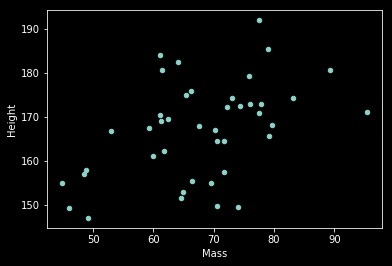

In [5]:
# Visualize metadata
plt.figure()
umeta.plot.scatter(x='Mass', y='Height')
plt.show()

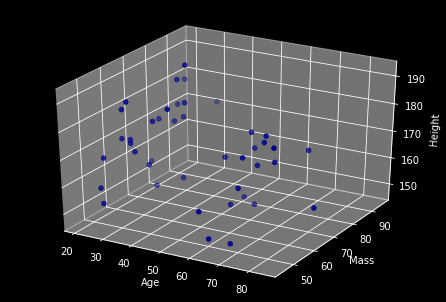

In [6]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(umeta['Age'], umeta['Mass'], umeta['Height'], color='darkblue')
ax.set_xlabel('Age')
ax.set_ylabel('Mass')
ax.set_zlabel('Height')
plt.show()

In [0]:
# Separate text files were generated for the markers and force signals, as the sample frequencies of the kinematics and kinetics data differed.
# Furthermore, the text files also contain the time-normalized ensemble average of the kinematics and kinetics curves for each participant at 
# each gait speed and for each environment condition (overground and treadmill). 
# The total number of gait trials is not the same across participants because it reflects the variation in the number of valid trials per participant.
filename = wget.download(url=WBDSascii, out='WBDSascii')
zf = ZipFile(filename)
os.remove(filename)

In [8]:
# Load pandas data frames

# There are 42 subjects
subjects = range(1, 43)

# This function returns the names of a subject's files 
# that contains processed kinematics, kinetic or raw data
# mode = 1 for kinematics during treadmill walking
# mode = 2 for kinetics during treadmill walking
# mode = 3 for raw data
# mode = 2 for kinetics during overground walking
def subject_files(sbj, mode=1):  
  if mode==1:
    # Angular ascii trheadmill file names
    # Processed files of kinematics
    pattern = 'WBDS[0-9][0-9]walkT[0-1][0-9]ang.txt'
  elif mode==2:
    # Processed files of kinetic data: joint moments during treadmill walking
    pattern = 'WBDS[0-9][0-9]walkT[0-1][0-9]knt.txt'
  elif mode==3:
    # Raw files
    pattern = 'WBDS[0-9][0-9]walk[T][0-1][0-9].c3d'
  elif mode==4:
    # Joint moments during overground walking
    pattern = 'WBDS[0-9][0-9]walk[O][0-1][0-9].c3d'
  files = meta[meta['FileName'].str.match(pattern)]
  return files.query('Subject=={0}'.format(sbj))['FileName'].values

def subject_features(subject_or_filename, features=['Gender', 'Age', 'Mass', 'Height']):
  #if 'GaitSpeed(m/s)' in features:
  if any('GaitSpeed(m/s)' in i for i in features):
    # Gait speed refers to a file
    return meta[meta['FileName']==subject_or_filename][features].values[0]
  # Returns features of a given subject
  return umeta[umeta['Subject']==subject_or_filename][features].values[0]
  
# Loads all files into one dataframe indexed by subject and filename
dataset = []
for s in subjects:
  dss = pd.concat([pd.read_csv(zf.open(f), sep='\t') for f in subject_files(s, mode=2)], keys = subject_files(s))
  dataset.append(dss)
dataset = pd.concat(dataset, keys = subjects)

#youngs = 24; 
#olders = 18;
# walking speeds classes: ('S','C','F')
# lower extremity joints/segments: ('Pelvis','Hip','Knee','Ankle','Foot')

# print the available columns, each column is a time series variable
print(dataset.columns)

Index(['Time', 'RHipMomentX', 'RHipMomentY', 'RHipMomentZ', 'LHipMomentX',
       'LHipMomentY', 'LHipMomentZ', 'RKneeMomentX', 'RKneeMomentY',
       'RKneeMomentZ', 'LKneeMomentX', 'LKneeMomentY', 'LKneeMomentZ',
       'RAnkleMomentX', 'RAnkleMomentY', 'RAnkleMomentZ', 'LAnkleMomentX',
       'LAnkleMomentY', 'LAnkleMomentZ', 'RGRFX', 'RGRFY', 'RGRFZ', 'LGRFX',
       'LGRFY', 'LGRFZ'],
      dtype='object')


In [0]:
# Alias for kinetic columns
column_alias_dictionary = {'RHipMomentX' : 'Hip Abd/Adduction', 'RHipMomentY' : 'Hip Ext/Internal Rotation', 'RHipMomentZ' : 'Hip Flexion/Extension', 
                           'LHipMomentX' : 'Hip Abd/Adduction', 'LHipMomentY' : 'Hip Ext/Internal Rotation', 'LHipMomentZ' : 'Hip Flexion/Extension', 
                           'RKneeMomentX': 'Knee Abd/Adduction', 'RKneeMomentY' : 'Knee Ext/Internal Rotation', 'RKneeMomentZ' : 'Knee Ext/Flexion', 
                           'LKneeMomentX': 'Knee Abd/Adduction', 'LKneeMomentY' : 'Knee Ext/Internal Rotation', 'LKneeMomentZ' : 'Knee Ext/Flexion', 
                           'RAnkleMomentX' : 'Ankle Ev/Inversion', 'RAnkleMomentY' : 'Ankle Abd/Adduction', 'RAnkleMomentZ' : 'Ankle PF/Dorsiflexion', 
                           'LAnkleMomentX' : 'Ankle Ev/Inversion', 'LAnkleMomentY' : 'Ankle Abd/Adduction', 'LAnkleMomentZ' : 'Ankle PF/Dorsiflexion'}
#dirM = {'Hip Abd/Adduction','Hip Ext/Internal Rotation','Hip Flexion/Extension', 'Knee Abd/Adduction','Knee Ext/Internal Rotation','Knee Ext/Flexion', 'Ankle Ev/Inversion','Ankle Abd/Adduction','Ankle PF/Dorsiflexion'}

#yaxisLim = [-1.5 1 -.5 1.5 -.4 .5 -1 1.5 -.5 1 -.2 .5 -.5 2 -.2 .4 -.2 1];


('GenderOriginal', 'F')
('Gender', 1)
('Age', 24)
('Mass', 48.8)
('Height', 158.0)


<Figure size 432x288 with 0 Axes>

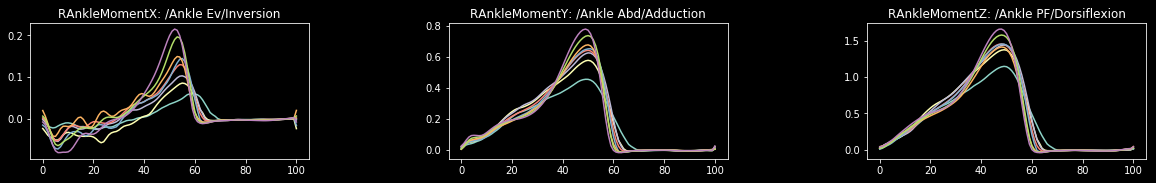

In [14]:
# Visualization of some variables
# https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html

# Pick an arbitrary subject and show some of it´s features
subject = 12
fts = ['GenderOriginal', 'Gender', 'Age', 'Mass', 'Height']
[print(x) for x in zip(fts, subject_features(subject, fts))]


# Each column is a variable to plot
#cols = [i for i in dataset.columns if i.startswith('LGRF')]
cols = [i for i in dataset.columns if i.startswith('RAnkle')]
#cols = dataset.columns[1:]

plt.clf()
fig = plt.figure(figsize=(20,2.5))
fig.subplots_adjust(hspace=.5, wspace=0.5)
for i, c in enumerate(cols):
  plt.subplot(len(cols)/3, 3, i+1, title='{0}: /{1}'.format(c, column_alias_dictionary.get(c)))
  #plt.plot(dataset.loc[subject]['Time'], dataset.loc[subject][c]) # sould replace the loop below
  for j, f in enumerate(subject_files(subject)): 
    plt.plot(dataset.loc[subject, f]['Time'], dataset.loc[subject, f][c], label='T0{0}'.format(j+1))
  plt.grid(False)
#plt.tight_layout()
plt.show()

# TODO: for paper plots check http://www.spm1d.org/

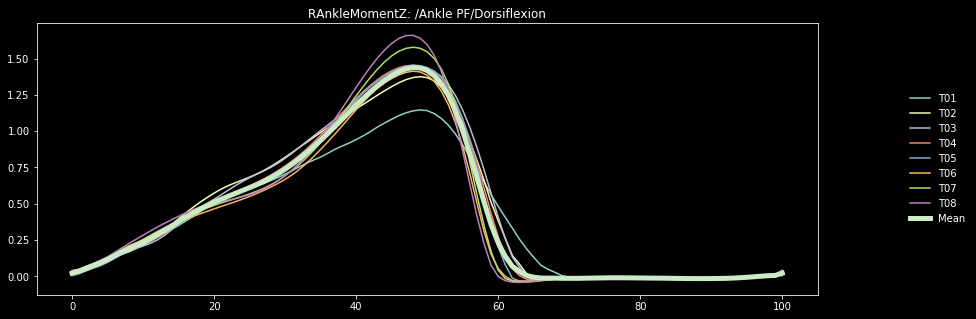

In [15]:
# This function plot each trial values of one variable
def plot_col(col):
  plt.figure(figsize=(14,5))
  for i, f in enumerate(subject_files(subject)): 
    ds = dataset.loc[subject, f]
    plt.plot(ds['Time'], ds[col], label='T0{0}'.format(i+1))
  # Plot the mean
  plt.plot(dataset.loc[subject, f]['Time'], dataset.loc[subject].groupby('Time')[col].mean(), label='Mean', linewidth=5)
  plt.legend(loc="right", frameon=False, bbox_to_anchor= (1.2, .5))
  plt.title('{0}: /{1}'.format(col, column_alias_dictionary.get(col)))
  plt.show()
  
# plot a variable among trails
plot_col('RAnkleMomentZ')

# Works too:
#dataset.loc[subject].plot(x='Time', y=col)
#dataset.loc[subject].groupby('Time')[col].mean().plot(x='Time', y=col, label='Mean', linewidth=5)

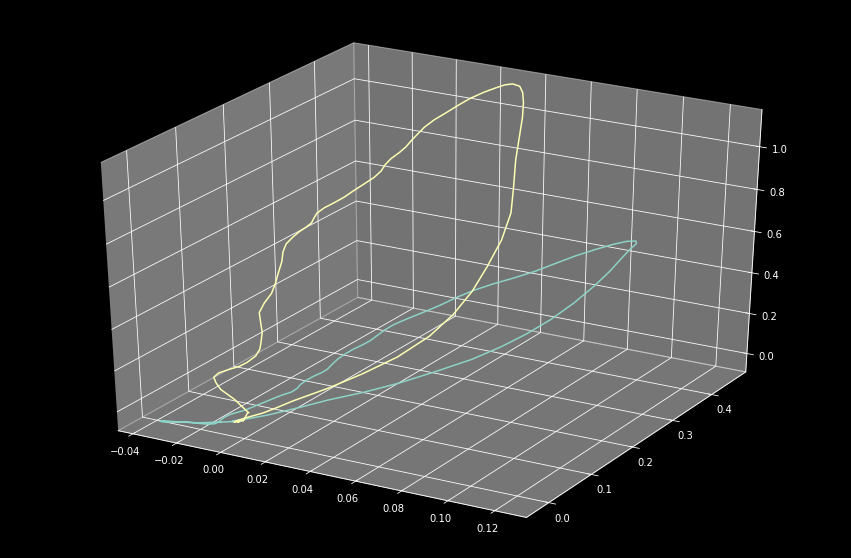

In [12]:
from matplotlib.animation import FuncAnimation
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111, projection='3d')

sd = dataset.loc[subject, subject_files(subject)[0]]
#for col in dataset.columns if (i.startswith('RHip') or i.startswith('RKnee') or i.startswith('RAnkle')):
for col in ['LAnkleMoment', 'RAnkleMoment']:
  ax1.plot(sd[col+'X'], sd[col+'Y'], sd[col+'Z'])
  

#for c_col, (c_grp, c_rows) in zip(cycle(colors), valid_df.groupby('point_label')):
#    ax1.plot(c_rows['x'], c_rows['y'], c_rows['z'], '-', label=c_grp, alpha=0.25, color=c_col)

#ax1.set_xlabel('x')
#ax1.set_ylabel('y')
#ax1.set_zlabel('z')
#ax1.set_zlim(-500, 1500)
#ax1.set_xlim(-500, 500)
#ax1.view_init(30, 5)

#plt.savefig(col_name, format='png', bbox_inches='tight')
# TODO: 

In [0]:
def update_frame(in_df):
  [(f.set_alpha(0.1), f.set_marker('None')) for f in ax1.get_lines()]
  for col in ['LAnkleMoment', 'RAnkleMoment']:
    ax1.plot(sd[col+'X'], sd[col+'Y'], sd[col+'Z'], '.', alpha=0.25)
  

out_path = '3d_animation.gif'
fa = FuncAnimation(fig, update_frame, sd)#.save(out_path, bitrate=8000, fps=8)

#fa.save(out_path, bitrate=8000, fps=8)
h = fa.to_html5_video()

from google.colab import files
files.download(h) 

plt.close('all')


#FileLink(out_path)

# 2. Train-test split by subject

---


Split data by subject generating train and test sets. Must split by subject since by file may let the model learn about tests subjects.

In [16]:
# Train and test sets preparation
#class_labels = ['Gender']
# TODO: Encode class labels and add a new column label that is the combination of them
#print(umeta[class_labels].head())
#le = preprocessing.LabelEncoder()
#meta_encoded = umeta[class_labels].apply(le.fit_transform, axis=0)

# Split the data by subject
train_subjects = set(random.sample(subjects, len(subjects)*2//3))
test_subjects = set(subjects) - train_subjects
print('train_subjects:', train_subjects)
print('test_subjects: ', test_subjects)

# Split the data by filename
# Generate X Y of all subjects
#X, Y = prepare_xy(subjects, cols)
# Split the data using sklearn, will result in data mixed among subjects
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.7, random_state=25)

train_subjects: {1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 24, 25, 26, 29, 30, 33, 35, 37, 38, 39}
test_subjects:  {32, 34, 3, 36, 40, 41, 42, 14, 15, 22, 23, 27, 28, 31}


In [98]:
# force validation by subject
validation_subjects = set(random.sample(train_subjects, len(train_subjects)*1//4))

train_subjects2 = set(train_subjects) - validation_subjects

print('train_subjects2:', train_subjects2)
print('validation_subjects: ', validation_subjects)


train_subjects2: {1, 2, 6, 7, 8, 12, 13, 16, 17, 19, 20, 21, 24, 25, 29, 30, 33, 35, 37, 38, 39}
validation_subjects:  {4, 5, 9, 10, 11, 18, 26}


In [0]:
# Generating normalized versions of the columns
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer

def apply_normalizer(normalizer, column, ds = dataset):
  return normalizer.fit_transform(ds[[column]])

def normalize_data():
  # Generate normalized columns
  for c in dataset.columns[1:]:
    #dataset[c+'StandardScaler'] = apply_normalizer(StandardScaler(), c)
    dataset[c+'MinMaxScaler'] = apply_normalizer(MinMaxScaler(), c)
    #dataset[c+'MaxAbsScaler'] = apply_normalizer(MaxAbsScaler(), c)
    #dataset[c+'RobustScaler'] = apply_normalizer(RobustScaler(), c)
    #dataset[c+'QuantileTransformer_gaussian'] = apply_normalizer(QuantileTransformer(output_distribution='normal'), c)
    #dataset[c+'QuantileTransformer_uniform'] = apply_normalizer(QuantileTransformer(output_distribution='uniform'), c)
    ##dataset[c+'Normalizer'] = apply_normalizer(Normalizer(), c)


  # TODO: convert   GaitSpeed string to float before********************************************************************************************************
  #TODO: normalize Age, Mass, Height and GaitSpeed columns  
  for c in ['Age', 'Mass', 'Height', 'GaitSpeed(m/s)']:  
    #meta[c+'StandardScaler'] = apply_normalizer(StandardScaler(), c, meta)
    meta[c+'MinMaxScaler'] = apply_normalizer(MinMaxScaler(), c, meta)
    #meta[c+'MaxAbsScaler'] = apply_normalizer(MaxAbsScaler(), c, meta)
    #meta[c+'RobustScaler'] = apply_normalizer(RobustScaler(), c, meta)
    #meta[c+'QuantileTransformer_gaussian'] = apply_normalizer(QuantileTransformer(output_distribution='normal'), c, meta)
    #meta[c+'QuantileTransformer_uniform'] = apply_normalizer(QuantileTransformer(output_distribution='uniform'), c, meta)
    ##meta[c+'Normalizer'] = apply_normalizer(Normalizer(), c, meta)

# 3. Time Series Generation

---


Aka.: Multi-step time series forecasting

See: [Lower limb sagittal gait kinematics can be predicted based on walking speed, gender, age and BMI](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6606631/) or read at [Nature](https://www.nature.com/articles/s41598-019-45397-4)

See also: https://www.sciencedirect.com/science/article/pii/S0957417413009032

f(x) = y where: x = (Gender, Age, Mass, Height, Speed), y = uni/milti Time Series

In [0]:
# Select the columns to be learned
y_cols = [i for i in dataset.columns if (i.startswith('RHip') or i.startswith('RKnee') or i.startswith('RAnkle'))]

# Preparation of the inputs
# y_cols = list with the names of columns with curves data
def prepare_yxs(sbjs, y_cols):
  # The x of an example will be Gender, Age, Mass, Height and Gait speed
  # The X stores all the x's
  X = []
  # The y of an example will be several multivariate time series
  # The Y stores all the y's
  # Create a list of y_cols empty lists
  Y = [[] for i in range(len(y_cols))]
  y0, y1, y2 = [], [], []
  for s in sbjs:
      for f, f_c3d in zip(subject_files(s), subject_files(s, mode=3)):
        X.append(subject_features(f_c3d, ['Gender', 'Age', 'Mass', 'Height', 'GaitSpeed(m/s)']))
        for i, y_col in enumerate(y_cols):
          Y[i].append(np.array([dataset.loc[s, f][y_col]]).reshape(-1))
  return np.array(X), Y

# Evaluation metrics between two 2D arrays
def metrics(golden, guess):
  from tslearn.metrics import dtw
  dt = dtw(golden, guess)
  mse = mean_squared_error(golden, guess)
  rmse = np.sqrt(mse)
  #nrmse = rmse / np.mean(golden)
  pearson_coef, _ = stats.pearsonr(golden.reshape(-1), guess.reshape(-1))  
  return mse, rmse, dt, pearson_coef 
  #Surrogate Time Series using Fourier Transform
  #https://stats.stackexchange.com/questions/204032/surrogate-time-series-using-fourier-transform
  
# Calculate and print the evaluation metrics of the network output
def print_scores(y_cols, y_test, y_pred):
  final_mse = 0
  final_rmse = 0
  final_dtw = 0
  final_p = 0
  final_count = 0
  for golden, guess, y_col in zip(y_test, y_pred, y_cols):
    avg_mse = 0
    avg_rmse = 0
    avg_dtw = 0
    avg_p = 0
    count = 0
    for trial_golden, trial_guess in zip(golden, guess):    
      mse, rmse, dtw, p = metrics(np.array(trial_golden), np.array(trial_guess))    
      avg_mse += mse
      avg_rmse += rmse
      avg_dtw += dtw
      avg_p += p
      count += 1  
    print('Test scores for ', y_col, 
            ': MSE = {0:4.2f}, RMSE = {1:4.2f}, DTW = {2:4.2f}, p = {3:4.2f}'
          .format(avg_mse/count, avg_rmse/count, avg_dtw/count, avg_p/count))  
    final_mse += avg_mse
    final_rmse += avg_rmse
    final_dtw += avg_dtw
    final_p += avg_p
    final_count += count

  print('Average scores: MSE = {0:4.2f}, RMSE = {1:4.2f}, DTW = {2:4.2f}, p = {3:4.2f}'
          .format(final_mse/final_count, final_rmse/final_count, final_dtw/final_count, final_p/final_count)) 
  
  return (final_mse/final_count, final_rmse/final_count, final_dtw/final_count, final_p/final_count)
  
  
# Visual comparation of golden average with correspondent average predicted by the model
def compare(golden, guess, col_name=None, Save=False):
  plt.figure(figsize=(12,5))
  plt.plot(range(0,101), guess.mean(axis=0), label='predicted')
  plt.plot(range(0,101), golden.mean(axis=0), label='golden')
  plt.legend()
  if col_name is not None:
    plt.title('{0}: /{1}'.format(col_name, column_alias_dictionary.get(col_name)))
  if Save:
    plt.savefig(col_name, format='png', bbox_inches='tight')
    # TODO: 
    #from google.colab import files
    #files.download(col_name) 
  else:
    plt.show()  
    
# Visualize the average golden x generated of each time series 
def visualize(y_cols, y_test, y_pred):
  plt.clf()
  #with plt.style.context(['grayscale', 'seaborn-paper']): #seaborn-white
  fig = plt.figure(figsize=(24,12))
  fig.subplots_adjust(hspace=.5, wspace=0.5)

  for i, y_col in enumerate(y_cols):
    plt.subplot(len(y_cols)/3, 3, i+1)
    plt.title('{0}: /{1}'.format(y_col, column_alias_dictionary.get(y_col), fontsize='x-large',fontweight='bold'))

    plt.plot(range(0,101), np.array(y_test[i]).mean(axis=0), label='golden', linewidth=3, color='black')
    plt.plot(range(0,101), y_pred[i].mean(axis=0), label='predicted', linewidth=3, color='grey')

    plt.grid(False)    
    plt.xlabel('Gait cycle(%)', fontsize='x-large')
    plt.ylabel('Nm/Kg', fontsize='x-large')

  plt.legend(loc='best', fontsize='xx-large')
  #leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
  #leg.get_frame().set_alpha(0.5)
  plt.tight_layout()
  plt.show()    

In [0]:
# Define, train and test a model to predict all the series at once

# Define FFNN model to predict all the curves at once
def prepare_tsg_ffnn_model(y_cols, hidden_units):
  # A tensor for the input features: gender, age, mass, height and gait speed
  inputs = keras.layers.Input(shape=(5,))

  # Hidden layers
  x = keras.layers.Dense(hidden_units, activation='sigmoid')(inputs)
  #x = keras.layers.Dense(hidden_units, activation='sigmoid')(x)

  # Output layer with the predictions for each curve
  output_layer = [keras.layers.Dense(101, activation='linear')(x) for y_col in y_cols]

  # This creates a model that includes the define layers
  model = keras.models.Model(inputs=inputs, outputs=output_layer)
  model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
  return model

In [0]:
# Define a custom RBF layer
# Radial basis networks are fully-conneced feedforward neural networks that use a radial basis function as their activation on their hidden layers.
# A radial basis function is any function which is defined as a function of distance from a certain central point (a radius).
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        smooth = K.sum(K.pow(diff,2), axis=1)
        res = K.exp(-1 * self.gamma * smooth)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)
      
      
# Custom activation function (Radial Basis Function - RBF)
def l2_norm(a, b): 
  return K.sqrt(((a - b) ** 2).sum())
del rbf_activation
def rbf_activation(x, gamma=25.0):
     return K.exp(-1 * gamma * l2_norm(x[0], x[1]) ** 2)      
def rbf_activation2(x):
  distance = l2_norm(x[0], x[1])
  smoothness = 50
  return K.exp(-1 * ((distance ** 2) / (2*(smoothness**2))))
            
# Define RBF model to predict all the curves at once
del prepare_rbf_model
def prepare_rbf_model(y_cols, hidden_units):
  # A tensor for the input features: gender, age, mass, height and gait speed
  inputs = keras.layers.Input(shape=(5,))

  # Hidden layers
  #x = keras.layers.Dense(50, activation='sigmoid')(inputs)

  # RBF
  x = RBFLayer(hidden_units, 15)(inputs)
  #x = keras.layers.Lambda(rbf_activation2, 101)(inputs)
  
  # Output layer with the predictions for each curve
  output_layer = [keras.layers.Dense(101, activation='linear')(x) for y_col in y_cols]

  # This creates a model that includes the define layers
  model = keras.models.Model(inputs=inputs, outputs=output_layer)
  model.compile(optimizer='sgd', loss='mse', metrics=['mse', 'mae'])
  return model


# Usage
#model = prepare_rbf_model(y_cols)

In [0]:
def train_test(prepare_model = prepare_tsg_ffnn_model, hidden_units=50, n_epochs = 500):
  # Prepare train and test sets
  x_train, y_train = prepare_yxs(train_subjects2, y_cols)
  #x_train, y_train = prepare_yxs(train_subjects, y_cols)
  x_validation, y_validation = prepare_yxs(validation_subjects, y_cols)
  x_test, y_test = prepare_yxs(test_subjects, y_cols)

  # Build the model
  model = prepare_model(y_cols, hidden_units)

  # Train the model
  print('Training {1} epochs: {0}'.format(y_cols, n_epochs))
  #model.fit(x_train, y_train, epochs=epcs, verbose=False)
  #model.fit(x_train, y_train, epochs=n_epochs, validation_split=0.25, verbose=False)
  model.fit(x_train, y_train, epochs=epcs, validation_data=(x_validation, y_validation), verbose=False)

  # Test the model
  y_pred = np.array(model.predict(x_test))

  # Evaluate
  scores = print_scores(y_cols, y_test, y_pred)
  
  # Compare
  visualize(y_cols, y_test, y_pred)

  # Finish
  del model
  keras.backend.clear_session()
  
  return scores

In [0]:
# underfit x overfit
ls = []
for n_hidden_units in range(1, 102):
  ls.append(train_test(hidden_units=n_hidden_units))

In [154]:
print(plt.style.available)

['seaborn-notebook', 'fivethirtyeight', '_classic_test', 'seaborn', 'seaborn-white', 'dark_background', 'seaborn-muted', 'seaborn-dark', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-deep', 'seaborn-dark-palette', 'seaborn-ticks', 'bmh', 'seaborn-talk', 'ggplot', 'tableau-colorblind10', 'fast', 'seaborn-pastel', 'seaborn-whitegrid', 'classic', 'Solarize_Light2', 'grayscale', 'seaborn-darkgrid', 'seaborn-poster', 'seaborn-paper']


In [0]:
plt.style.use(['seaborn-white'])
#plt.figure(figsize=(16,9))
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.plot(range(0,101), [e[1:] for e in ls], linewidth=8)
plt.legend(labels=('RMSE', 'DTW', 'p'), fontsize=24, bbox_to_anchor= (1.22, 1))
plt.xlabel('Hidden units', fontsize='25', fontweight='bold')
plt.ylabel('Metric value', fontsize='25', fontweight='bold')
plt.tick_params(direction='out', length=6, width=2,grid_alpha=1, labelsize='20')
plt.show()  

In [0]:
plt.style.use(['grayscale'])
train_test(hidden_units=20) # underfit x overfit

Training 500 epochs: ['RHipMomentX', 'RHipMomentY', 'RHipMomentZ', 'RKneeMomentX', 'RKneeMomentY', 'RKneeMomentZ', 'RAnkleMomentX', 'RAnkleMomentY', 'RAnkleMomentZ']
Test scores for  RHipMomentX : MSE = 0.01, RMSE = 0.11, DTW = 0.53, p = 0.95
Test scores for  RHipMomentY : MSE = 0.00, RMSE = 0.04, DTW = 0.21, p = 0.93
Test scores for  RHipMomentZ : MSE = 0.05, RMSE = 0.19, DTW = 1.33, p = 0.92
Test scores for  RKneeMomentX : MSE = 0.01, RMSE = 0.09, DTW = 0.48, p = 0.93
Test scores for  RKneeMomentY : MSE = 0.00, RMSE = 0.03, DTW = 0.14, p = 0.96
Test scores for  RKneeMomentZ : MSE = 0.03, RMSE = 0.15, DTW = 1.02, p = 0.83
Test scores for  RAnkleMomentX : MSE = 0.01, RMSE = 0.06, DTW = 0.38, p = 0.60
Test scores for  RAnkleMomentY : MSE = 0.01, RMSE = 0.07, DTW = 0.35, p = 0.95
Test scores for  RAnkleMomentZ : MSE = 0.03, RMSE = 0.15, DTW = 0.58, p = 0.96
Average scores: MSE = 0.02, RMSE = 0.10, DTW = 0.56, p = 0.89


<Figure size 432x288 with 0 Axes>

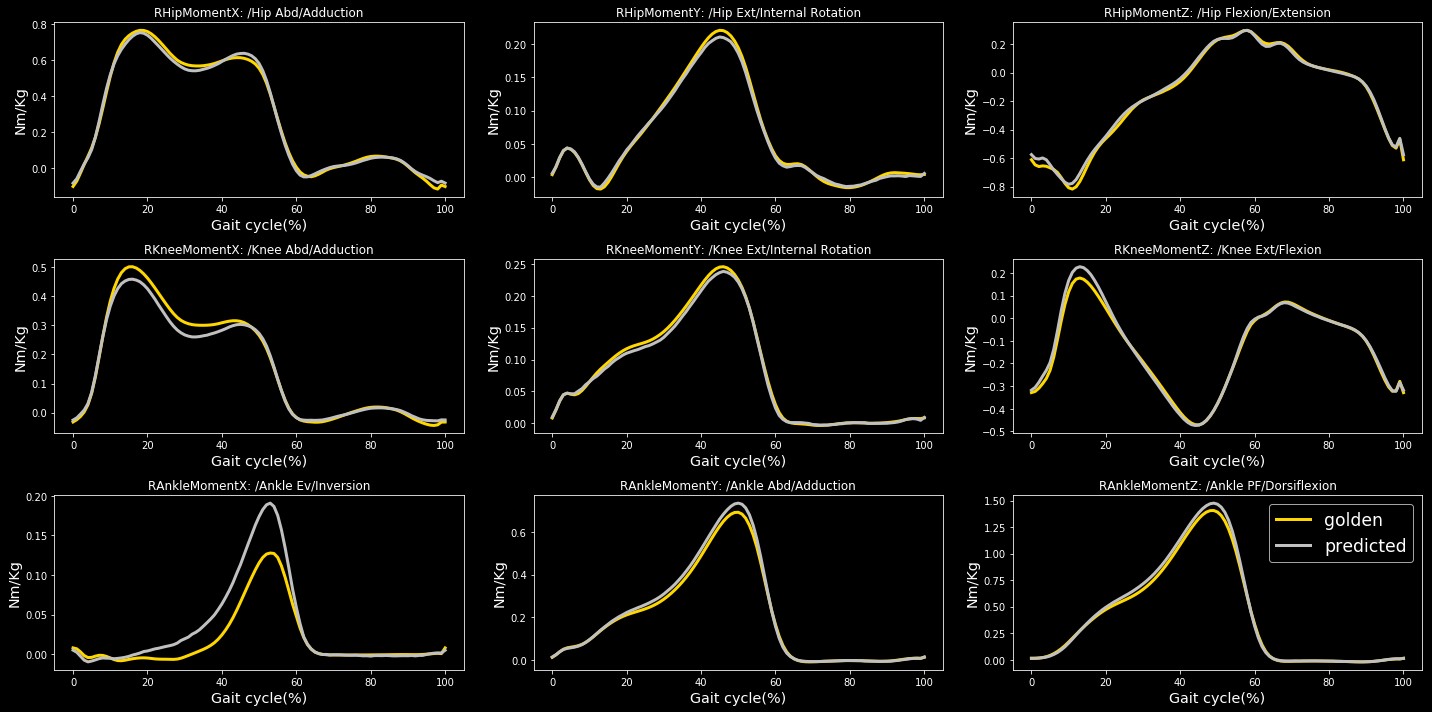

In [108]:
train_test(hidden_units=50)

Training 500 epochs: ['RHipMomentX', 'RHipMomentY', 'RHipMomentZ', 'RKneeMomentX', 'RKneeMomentY', 'RKneeMomentZ', 'RAnkleMomentX', 'RAnkleMomentY', 'RAnkleMomentZ']
Test scores for  RHipMomentX : MSE = 0.01, RMSE = 0.11, DTW = 0.53, p = 0.95
Test scores for  RHipMomentY : MSE = 0.00, RMSE = 0.04, DTW = 0.20, p = 0.93
Test scores for  RHipMomentZ : MSE = 0.05, RMSE = 0.19, DTW = 1.33, p = 0.92
Test scores for  RKneeMomentX : MSE = 0.01, RMSE = 0.09, DTW = 0.48, p = 0.93
Test scores for  RKneeMomentY : MSE = 0.00, RMSE = 0.03, DTW = 0.14, p = 0.96
Test scores for  RKneeMomentZ : MSE = 0.03, RMSE = 0.15, DTW = 1.01, p = 0.83
Test scores for  RAnkleMomentX : MSE = 0.01, RMSE = 0.06, DTW = 0.38, p = 0.60
Test scores for  RAnkleMomentY : MSE = 0.01, RMSE = 0.07, DTW = 0.35, p = 0.95
Test scores for  RAnkleMomentZ : MSE = 0.03, RMSE = 0.15, DTW = 0.58, p = 0.96
Average scores: MSE = 0.02, RMSE = 0.10, DTW = 0.56, p = 0.89


<Figure size 432x288 with 0 Axes>

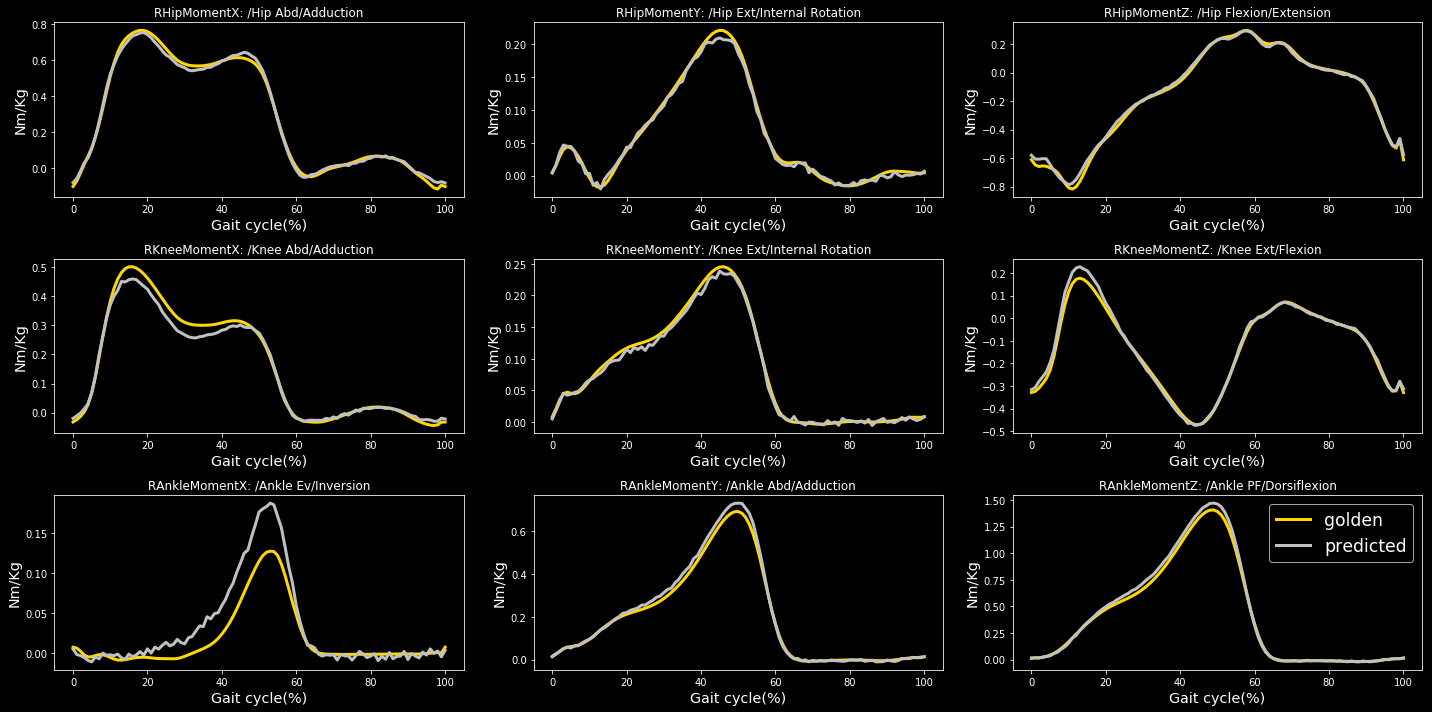

In [109]:
train_test(hidden_units=64)

Training 500 epochs: ['RHipMomentX', 'RHipMomentY', 'RHipMomentZ', 'RKneeMomentX', 'RKneeMomentY', 'RKneeMomentZ', 'RAnkleMomentX', 'RAnkleMomentY', 'RAnkleMomentZ']
Test scores for  RHipMomentX : MSE = 0.01, RMSE = 0.11, DTW = 0.52, p = 0.95
Test scores for  RHipMomentY : MSE = 0.00, RMSE = 0.04, DTW = 0.22, p = 0.92
Test scores for  RHipMomentZ : MSE = 0.05, RMSE = 0.20, DTW = 1.33, p = 0.92
Test scores for  RKneeMomentX : MSE = 0.01, RMSE = 0.10, DTW = 0.50, p = 0.92
Test scores for  RKneeMomentY : MSE = 0.00, RMSE = 0.03, DTW = 0.16, p = 0.95
Test scores for  RKneeMomentZ : MSE = 0.03, RMSE = 0.15, DTW = 1.01, p = 0.82
Test scores for  RAnkleMomentX : MSE = 0.01, RMSE = 0.07, DTW = 0.43, p = 0.57
Test scores for  RAnkleMomentY : MSE = 0.01, RMSE = 0.08, DTW = 0.38, p = 0.95
Test scores for  RAnkleMomentZ : MSE = 0.03, RMSE = 0.15, DTW = 0.61, p = 0.96
Average scores: MSE = 0.02, RMSE = 0.10, DTW = 0.57, p = 0.89


<Figure size 432x288 with 0 Axes>

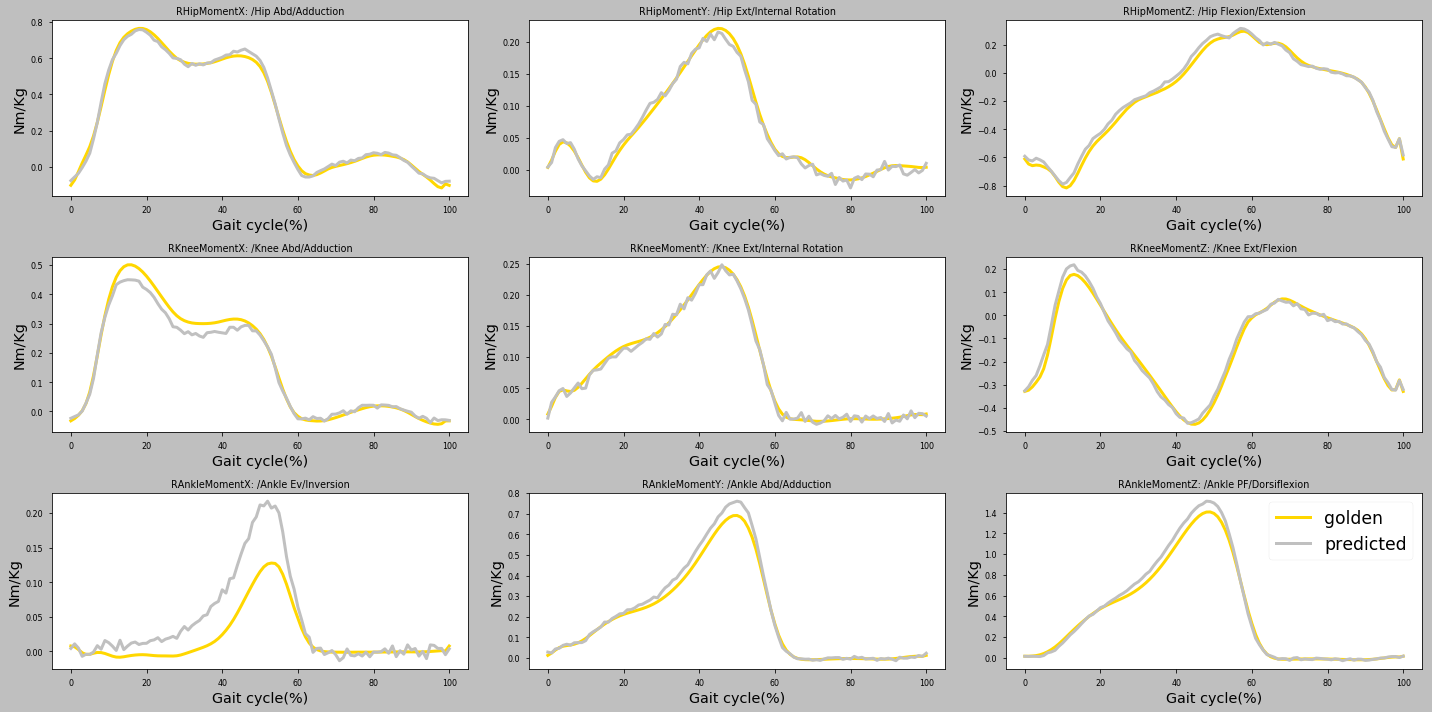

In [92]:
train_test(hidden_units=101)

In [0]:
# Alternative implementation
fig, axs = plt.subplots(3, 3, sharex=True, figsize=(20,10))
fig.suptitle('Golden x Predicted')
for i, ax in enumerate(axs):
  ax.plot(range(0, 101), y_pred[i].mean(axis=0), label='predicted')
  ax.plot(range(0, 101), np.array(y_test[i]).mean(axis=0), label='golden')
  
# Plot side by side
#fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,4))
#fig.suptitle('Golden x Predicted')
#ax1.plot(x, y_test[1])
#ax1.plot(x, y_pred[1])
#ax2.plot(x, y_pred[1])

<Figure size 432x288 with 0 Axes>

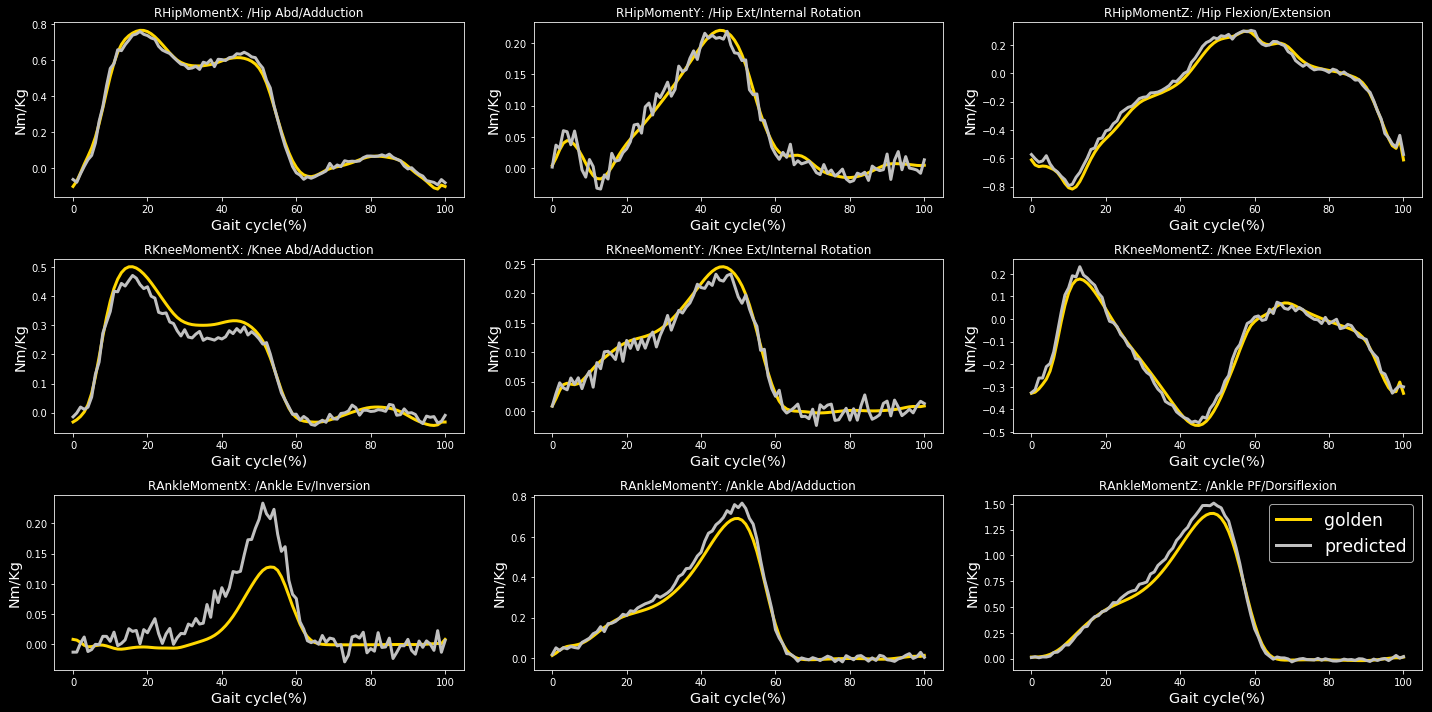

In [74]:
visualize(y_cols, y_pred, y_test)

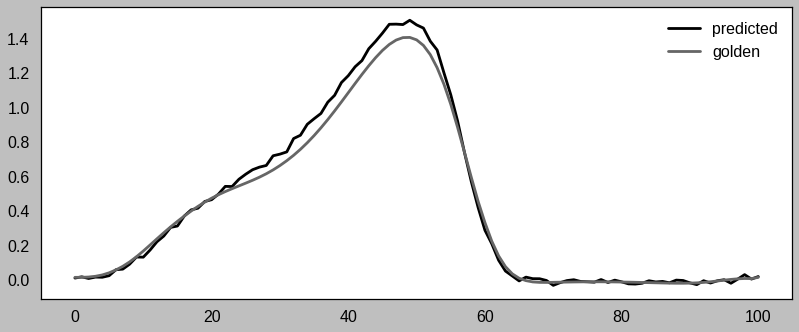

In [364]:
compare(np.array(y_test[8]), y_pred[8])

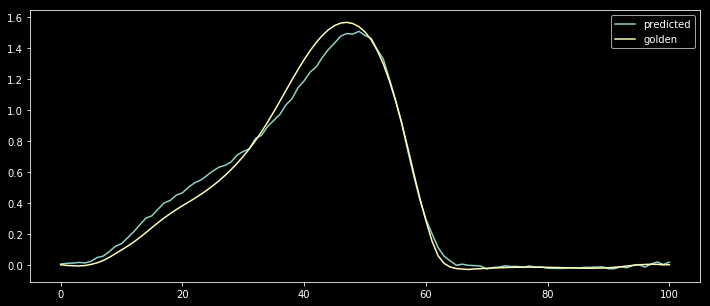

In [31]:
plt.figure(figsize=(12,5))
plt.plot(range(0,101), y_pred[8, 50], label='predicted')
plt.plot(range(0,101), np.array(y_test)[8, 50], label='golden')
plt.legend()
plt.show()

In [42]:
 np.array(y_train[0]).shape

(220, 101)

In [0]:
np.apply_along_axis(my_func, 0, y_train)

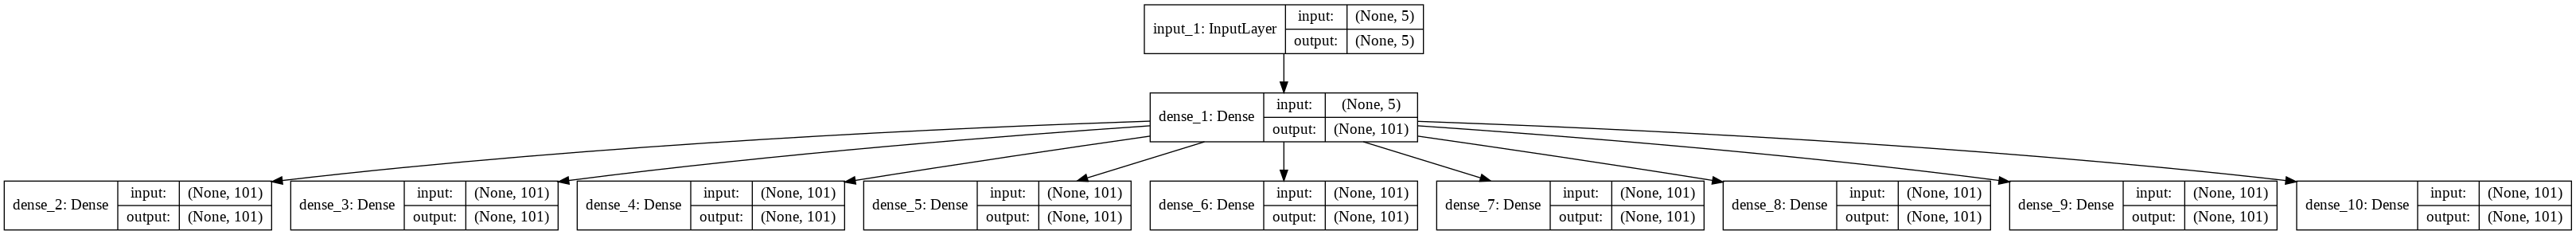

In [0]:
from keras.utils import plot_model
#plot_model(model, to_file='model.png')

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

from IPython.display import Image
Image(retina=True, filename='model.png')

In [0]:
# Extreme Learning Machine
# https://www.kaggle.com/robertbm/extreme-learning-machine-example

In [0]:
# TODO: Reproduce the following networks

# Generalized regression neural network (GRNN) (RBN instance) to predict Furrier coefficients
# https://www.sciencedirect.com/science/article/pii/S0966636213005869


# Wavelet(WNN) 
# https://www.sciencedirect.com/science/article/pii/S0957417413009032#b0100

# 4. Time Series Classification

---



* learn to classify between Male and Female gait (this notebook)
* learn to classify between Elderly and Young gait
* learn to classify between Overground and Treadmill gait, in case of Overground, learn to classify among Slow, Confortable and Fast gait
* regression tasks, e.g., learn to predict gait speed (m/s), learn to predict subject age

In [0]:
# Data preparation

def prepare_xy(sbjs, time_series_cols, class_label='Gender'):  
  # This function returns machine learning examples for a list of subjects
  # Each subject has several multivariate time series
  # Each example is a pair (x, y) 
  # Capital X will store the x's and Y will store the y's
  X, Y = [], []
  # The x of an example will be all the multivariate time series of a subject
  for s in sbjs:
      for f in subject_files(s):
        X.append(np.array(dataset.loc[s, f][time_series_cols.values]))
        Y.append(subject_features(s, class_label))
  return np.array(X), np.array(Y)

cols = dataset.columns
# Omit the time column since the data is uniform over time and there is no missing values
# cols = dataset.columns[1:]

x_train, y_train = prepare_xy(train_subjects, cols)
x_test, y_test = prepare_xy(test_subjects, cols)

# The number of classes
#nb_classes = len(np.unique(np.concatenate((y_train,y_test),axis =0)))
# Encode labels
#y_train_encoded, y_test_encoded = prepare_labels(y_train, y_test)  

print(train_subjects, x_train.shape, y_train.shape)
print(test_subjects, x_test.shape, y_test.shape)

{2, 4, 8, 9, 11, 12, 13, 15, 16, 17, 18, 20, 21, 23, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36, 37, 39, 40, 41} (218, 101, 49) (218,)
{32, 1, 3, 5, 6, 7, 38, 10, 42, 14, 19, 22, 24, 31} (110, 101, 49) (110,)


In [0]:
# LSTM baseline 

# Keras LSTM expected input shape is of the format [#timesteps, #features]
in_shape = x_train.shape[1:]
output_dim = 1

# https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/
model = keras.models.Sequential()
model.add(keras.layers.LSTM(64, input_shape=in_shape))
#model.add(keras.layers.Dense(32, activation='sigmoid'))
#model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(output_dim, activation='softmax'))
#model.summary()
# Train
chk = keras.callbacks.ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=0)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, validation_split=0.12, epochs=10, batch_size=128, callbacks=[chk])

del model
del chk

In [0]:
# Test
model = keras.models.load_model('best_model.pkl')
y_pred = model.predict_classes(x_test)
print('Test score: {0}'.format(accuracy_score(y_test.reshape(-1,), y_pred))) # Test score: 0.57
keras.backend.clear_session()

Test score: 0.43636363636363634


/usr/local/lib/python3.6/dist-packages/keras/engine/sequential.py:272: RuntimeWarning: invalid value encountered in greater
  return (proba > 0.5).astype('int32')


In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred.reshape(-1)))

[[48  0]
 [62  0]]


In [0]:
# State-of-the-art

# Clone the repo "Deep Learning for Time Series Classification"
# https://github.com/hfawaz/dl-4-tsc
!git clone -l -s https://github.com/hfawaz/dl-4-tsc.git cloned-repo
%cd cloned-repo
#!ls

import utils.utils
import classifiers

!mkdir experiments

input_shape = x_train.shape[1:]
output_directory = 'experiments'
#classifier = create_classifier(classifier_name,input_shape, nb_classes, output_directory)
nb_classes = len(np.unique(np.concatenate((y_train,y_test),axis =0)))
from classifiers import fcn
classifier = fcn.Classifier_FCN(output_directory,input_shape, nb_classes, verbose=True)

# make the min to zero of labels
from utils.utils import transform_labels
y_train,y_test = transform_labels(y_train,y_test)

# save orignal y because later we will use binary
y_true = y_test.astype(np.int64) 
# transform the labels from integers to one hot vectors
enc = preprocessing.OneHotEncoder()
enc.fit(np.concatenate((y_train,y_test),axis =0).reshape(-1,1))
y_train = enc.transform(y_train.reshape(-1,1)).toarray()
y_test = enc.transform(y_test.reshape(-1,1)).toarray()

if len(x_train.shape) == 2: # if univariate 
    # add a dimension to make it multivariate with one dimension 
    x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],1))
    x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))

input_shape = x_train.shape[1:]

# y_true = y_test TODO: pass correct y_true
classifier.fit(x_train,y_train,x_test,y_test, y_test) # TODO: see test score

# 5. Generate synthetic time series data

---



And repeat step 3 but using the synthetic data to augment the train set

# 6. Results

---

Training epochs:  500
Test scores for  RHipMomentX : MSE = 0.01, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  RHipMomentY : MSE = 0.00, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  RHipMomentZ : MSE = 0.04, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  LHipMomentX : MSE = 0.01, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  LHipMomentY : MSE = 0.00, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  LHipMomentZ : MSE = 0.03, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  RKneeMomentX : MSE = 0.01, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  RKneeMomentY : MSE = 0.00, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  RKneeMomentZ : MSE = 0.03, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  LKneeMomentX : MSE = 0.01, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  LKneeMomentY : MSE = 0.00, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  LKneeMomentZ : MSE = 0.03, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  RAnkleMomentX : MSE = 0.00, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  RAnkleMomentY : MSE = 0.01, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  RAnkleMomentZ : MSE = 0.03, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  LAnkleMomentX : MSE = 0.00, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  LAnkleMomentY : MSE = 0.00, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Test scores for  LAnkleMomentZ : MSE = 0.02, RMSE = 0.11, pearson_coef, p_value = (0.94, 0.00)
Average scores: MSE = 0.01, RMSE = 0.10, p = 0.82


## Discussion
1. Applied state-of-the art neural net architecture for time series classification
2. We showed how to classify gait gender with using an LSTM architecture.

Use mountains images to generate artificial curves motivated by the fact that patterns repeats in different objects and actions in Nature.

##Conclusion

1. Train-test split must leave subjects out of train set, otherwise the model might learn about test data at training
3. The classification accuracy reveals that it is a difficult task (perhaps that there is a lack of data volume)

## Further work

1. E.g. gender classification could be beneficiated done using the raw image 
2. development of synthetic ‘benchmarking’ datasets for gait

In [0]:
# Build, train and test a FFNN model to predict one curve

# Use norm_col = 'MinMaxScaler' for normalized values
def prepare_yx(sbjs, y_col, norm_col=''):
  # The x of an example will be Gender, Age, Mass, Height and Gait speed
  # The y of an example will be a multivariate time series
  X, Y = [], []
  for s in sbjs:
      for f, f_c3d in zip(subject_files(s), subject_files(s, mode=3)):
        Y.append(np.array(dataset.loc[s, f][y_col+norm_col]))
        X.append(subject_features(f_c3d, ['Gender', 'Age'+norm_col, 'Mass'+norm_col, 'Height'+norm_col, 'GaitSpeed(m/s)'+norm_col]))
  return np.array(X), np.array(Y)

# FFNN baseline
# https://keras.io/getting-started/sequential-model-guide/
def tsg_ffnn(epcs, y_col):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(5, activation='sigmoid', input_dim=5))
  model.add(keras.layers.Dense(50, activation='sigmoid'))
  model.add(keras.layers.Dense(101, activation='elu'))
  # For a mean squared error regression problem
  model.compile(optimizer='sgd', loss='mse')

  x_train, y_train = prepare_yx(train_subjects, y_col)
  x_test, y_test = prepare_yx(test_subjects, y_col)

  #model.fit(x_train, y_train, epochs=epcs, validation_data=(x_test, y_test), verbose=False)
  model.fit(x_train, y_train, epochs=epcs, validation_split=0.2, verbose=False)

  #print(model.evaluate(x_test, y_test))

  # Test
  y_pred = model.predict(x_test)
  mse, rmse, nrmse, p = metrics(y_test, y_pred)
  
  keras.backend.clear_session()
  del model
  
  return y_test, y_pred, mse, rmse, nrmse, p
  # For state-of-the-art neural network architectures for TSG refer to
  # "Quick and Easy Time Series Generation with Established Image-based GANs"
  # https://www.groundai.com/project/quick-and-easy-time-series-generation-with-established-image-based-gans/
  
# Train and test only one curve
ggolden, gguess, mse, rmse, dtw, p = tsg_ffnn(150, 'RHipMomentZ')
print(mse, rmse, dtw, p)

# Verify consistency within numpy implementations of metrics
# Cross-correlation
#print(np.correlate(ggolden.reshape(-1), gguess.reshape(-1)))
# Pearson product-moment correlation coefficients
#print(np.corrcoef(ggolden.reshape(-1), gguess.reshape(-1)))
  
print(metrics(ggolden.mean(axis=0), gguess.mean(axis=0)))
compare(ggolden, gguess)


# Build, train and test one model for each series
avg_mse = 0
avg_rmse = 0
avg_dtw = 0
avg_p = 0
count = 1
# Train and test a model for each time serie variable and print the test scores
epcs = 500
print ('Training epochs: ', epcs)
#cols = [i for i in dataset.columns if (i.startswith('RHip') or i.startswith('RKnee') or i.startswith('RAnkle'))]
cols = dataset.columns[1:-6]
for y_col in cols:
  y_golden, y_guess, mse, rmse, dtw, p = tsg_ffnn(epcs, y_col)
  avg_mse += mse
  avg_rmse += rmse
  avg_dtw += nrmse
  avg_p += p
  count += 1
  
  #plt.figure(figsize=(9,3))
  #for row in y_guess: 
  #  plt.plot(range(0,101), row, label='T0{0}'.format(i))
  #plt.legend(loc="right", frameon=False, bbox_to_anchor= (1.2, .5))
  #plt.title(y_col)
  #plt.show()
  
  print('Test scores for ', y_col, 
        ': MSE = {0:4.2f}, RMSE = {1:4.2f}, DTW = {2:4.2f}, p = {3:4.2f}'
        .format(mse, rmse, dtw, p))  

print('Average scores: MSE = {0:4.2f}, RMSE = {1:4.2f}, DTW = {2:4.2f}, p = {3:4.2f}'
      .format(avg_mse/count, avg_rmse/count, avg_dtw/count, avg_p/count))